# Import

In [1]:
# System
import os
import time
import json

# Data processing
import numpy as np
import math

# Plot
import matplotlib.pyplot as plt

# ML
    # pytorch
import torch 
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, StepLR
torch.set_num_threads(4) # Processor Setting
    # VAR
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import MinMaxScaler
    # ESN
from scipy import linalg
from sklearn.linear_model import Ridge

# Config

In [2]:
# Config path
root = '/Volumes/Expansion/User_Backup/b08209033/111-2_IVT_analysis/'
file = 'config.json'
config_path = os.path.join(root, file)

# Import config
with open(config_path) as infile:
    config = json.load(infile)
    infile.close()

# Update config
    # ML Parameters
        # DataLoader
config.update({"ML_hyperparam_lookback": 7})
config.update({"ML_hyperparam_batch_size": 32})
        # Epoch
config.update({"ML_hyperparam_nepochs": 1000})
config.update({"ML_hyperparam_early_stop": 20})
        # optim
config.update({"ML_hyperparam_learning_rate": 3e-4})
config.update({"ML_hyperparam_weight_decay": 1e-6})
    # ML Fpath
config.update({"ML_path_model": os.path.join(config["Path_root"], "models")})
config.update({"ML_fname_model": "model.pt"})

# Export config
with open(config_path, 'w') as outfile:
    json.dump(config, outfile, sort_keys=True)
    outfile.close()

### Pytorch parallel computing (optional)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


# DataLoader

### Split observation and prediction

In [4]:
os.chdir(config["Path_IVT_calculation"])
with np.load(config["ML_fname_dataset"]) as dataset:
    train_set = dataset["train"]
    valid_set = dataset["valid"]
    test_set  = dataset["test"]

feature_num = config["Var_Feature_num_SVD"] + config["Flag_timeline_feature"] # optional feature

In [5]:
# Train set
train_len = config["ML_split_size"][0] - config["ML_hyperparam_lookback"]
X_train = np.zeros((train_len, 
                    config["ML_hyperparam_lookback"], 
                    feature_num))
Y_train = np.zeros((train_len, 
                    1, 
                    feature_num))
for i in range(train_len):
    X_train[i,:,:] = train_set[i:i+config["ML_hyperparam_lookback"],:]
    Y_train[i,:,:] = train_set[i+config["ML_hyperparam_lookback"],:].reshape(1, -1)

In [6]:
# Valid set
valid_len = config["ML_split_size"][1] - config["ML_hyperparam_lookback"]
X_valid = np.zeros((valid_len, 
                    config["ML_hyperparam_lookback"], 
                    feature_num))
Y_valid = np.zeros((valid_len, 
                    1, 
                    feature_num))
for i in range(valid_len):
    X_valid[i,:,:] = valid_set[i:i+config["ML_hyperparam_lookback"],:]
    Y_valid[i,:,:] = valid_set[i+config["ML_hyperparam_lookback"],:].reshape(1, -1)

In [7]:
# Test set
test_len = config["ML_split_size"][2] - config["ML_hyperparam_lookback"]
X_test = np.zeros((test_len, 
                   config["ML_hyperparam_lookback"], 
                   feature_num))
Y_test = np.zeros((test_len, 
                   1, 
                   feature_num))
for i in range(test_len):
    X_test[i,:,:] = test_set[i:i+config["ML_hyperparam_lookback"],:]
    Y_test[i,:,:] = test_set[i+config["ML_hyperparam_lookback"],:].reshape(1, -1)

### Encapsulate to Dataloader

In [8]:
# To Tensor
X_train = torch.from_numpy(X_train).type(torch.FloatTensor)
Y_train = torch.from_numpy(Y_train).type(torch.FloatTensor)
X_valid = torch.from_numpy(X_valid).type(torch.FloatTensor)
Y_valid = torch.from_numpy(Y_valid).type(torch.FloatTensor)
X_test  = torch.from_numpy(X_test).type(torch.FloatTensor)
Y_test  = torch.from_numpy(Y_test).type(torch.FloatTensor)

In [9]:
# To Dataset
train_data = TensorDataset(X_train, Y_train)
valid_data = TensorDataset(X_valid, Y_valid)
test_data  = TensorDataset(X_test,  Y_test)

In [10]:
# To DataLoader
train_loader = DataLoader(train_data, 
                          batch_size = config["ML_hyperparam_batch_size"],
                          shuffle = False,
                          pin_memory = True)
valid_loader = DataLoader(valid_data, 
                          batch_size = config["ML_hyperparam_batch_size"],
                          shuffle = False,
                          pin_memory = True)
test_loader  = DataLoader(test_data, 
                          batch_size = config["ML_hyperparam_batch_size"],
                          shuffle = False,
                          pin_memory = True)

# GRU

## Model structure

In [11]:
class GRU_FC(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRU_FC, self).__init__()
        # Parameter
        self.input_length = input_size
        self.num_layers = num_layers
        self.hidden_dim = hidden_size
        # Structure
        self.GRU = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.FC = nn.Linear(hidden_size, output_size)
        # Weight init
        self.GRU.weight_ih_l0.data.fill_(0)
        self.GRU.weight_hh_l0.data.fill_(0)
        self.FC.weight.data.fill_(0)
    
    def forward(self, x):
        # Hidden init
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        # GRU pass
        out, (hn) = self.GRU(x, (h0.detach()))
        # FC pass
        out = self.FC(out[:, -1, :])
        # Output
        out = torch.reshape(out, (out.size()[0], 1, out.size()[-1]))
        return out
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = torch.ones(self.num_layers, batch_size, self.hidden_dim).to(device)
        return hidden

## Execute setting

In [12]:
def trainer(train_loader, valid_loader, model, config, device):
    # Pre train stage
        # model_dict
    if not os.path.isdir('./models'):
        os.mkdir('./models') 
        # Epoch
    n_epochs, step, early_stop_count = config['ML_hyperparam_nepochs'], 0, 0
        # Loss function
    best_loss = math.inf
    criterion = nn.MSELoss(reduction='mean').to(device)
    mean_train_loss_record = []
    mean_valid_loss_record = []
        # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr = config['ML_hyperparam_learning_rate'], 
                                 weight_decay = config['ML_hyperparam_weight_decay'])
        # Scheduler
    scheduler_CAWR = CosineAnnealingWarmRestarts(optimizer, 
                                                 T_0     = 50, 
                                                 T_mult  = 5, 
                                                 eta_min = config['ML_hyperparam_weight_decay']/1e4)
    scheduler_SLR = StepLR(optimizer, 
                           step_size = 50, 
                           gamma     = 0.3)

    # Training & Validating stage
    # In each epoch
        # Learn all train data one time
        # Learn all valid data one time
        # Evaluate learning progress
    for epoch in range(n_epochs):
        # Init
        model.train() # TRAIN
        loss_record = []
        for batch, (x, y) in enumerate(train_loader):
            optimizer.zero_grad() # Reset gradient
            x, y = x.to(device), y.to(device)
            pred = model(x)
            loss = criterion(pred[:,-1,:], y[:,-1,:]) # Calculate loss
            loss.backward() # Backward propagation
            optimizer.step() # Update model parameter
            step += 1
            loss_record.append(loss.detach().item())
            
        scheduler_CAWR.step() # Update learning rate
        #scheduler_SLR.step()
        
        mean_train_loss_record.append(sum(loss_record)/len(loss_record))
        
        # Init
        model.eval() # VALIDATE
        loss_record = []
        for (x, y) in valid_loader:
            with torch.no_grad():
                x, y = x.to(device), y.to(device)
                pred = model(x)
                loss = criterion(pred[:,-1,:], y[:,-1,:]) # Calculate loss
            # Detach loss
            loss_record.append(loss.item())
            
        # Valid loss
        mean_valid_loss_record.append(sum(loss_record)/len(loss_record))
        
        # Show progress
        if (epoch%10==0):
            print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss_record[-1]:.7f}, Valid loss: {mean_valid_loss_record[-1]:.7f}')
        
        # Save model parameter if better
        if mean_valid_loss_record[-1] < best_loss:
            best_loss = mean_valid_loss_record[-1]
            os.chdir(config["ML_path_model"])
            torch.save(model, config["ML_fname_model"])
            early_stop_count = 0
        else: 
            early_stop_count += 1
            
        # Early stop
        if early_stop_count >= config['ML_hyperparam_early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return mean_train_loss_record, mean_valid_loss_record
    
    return mean_train_loss_record, mean_valid_loss_record


## Train

In [13]:
os.chdir(config["Path_root"])
model = GRU_FC(input_size  = feature_num,
               hidden_size = 160,
               output_size = feature_num,
               num_layers  = 1).to(device) # put your model and data on the same computation device.
train_loss, valid_loss = trainer(train_loader, valid_loader, model, config, device)

Epoch [1/1000]: Train loss: 0.0508381, Valid loss: 0.0883271
Epoch [11/1000]: Train loss: 0.0157049, Valid loss: 0.0320483
Epoch [21/1000]: Train loss: 0.0114056, Valid loss: 0.0223604
Epoch [31/1000]: Train loss: 0.0110047, Valid loss: 0.0215549
Epoch [41/1000]: Train loss: 0.0108280, Valid loss: 0.0212998
Epoch [51/1000]: Train loss: 0.0111564, Valid loss: 0.0214288
Epoch [61/1000]: Train loss: 0.0106097, Valid loss: 0.0206916
Epoch [71/1000]: Train loss: 0.0101110, Valid loss: 0.0200020
Epoch [81/1000]: Train loss: 0.0096666, Valid loss: 0.0195266
Epoch [91/1000]: Train loss: 0.0092950, Valid loss: 0.0192462
Epoch [101/1000]: Train loss: 0.0089785, Valid loss: 0.0190811
Epoch [111/1000]: Train loss: 0.0087018, Valid loss: 0.0189696
Epoch [121/1000]: Train loss: 0.0084589, Valid loss: 0.0188555
Epoch [131/1000]: Train loss: 0.0082432, Valid loss: 0.0187297
Epoch [141/1000]: Train loss: 0.0080509, Valid loss: 0.0185923
Epoch [151/1000]: Train loss: 0.0078798, Valid loss: 0.0184506
Epo

## Test

In [14]:
model.eval()
GRU_predict = [] # Predict
GRU_truth = [] # Ground_truth
for i, (x, y) in enumerate(test_loader):
    x = x.to(device)
    y = y.to(device)
    with torch.no_grad():
        pred = model(x)
        GRU_predict.append(pred.detach().cpu()[:,-1,:])
        GRU_truth.append(y.detach().cpu()[:,-1,:])
GRU_predict = torch.cat(GRU_predict, dim=0).numpy()
GRU_truth = torch.cat(GRU_truth, dim=0).numpy()
print(GRU_predict.shape)
print(GRU_truth.shape)

(2935, 39)
(2935, 39)


# VAR

## Train

In [15]:
AR_p = config["ML_hyperparam_lookback"]
results = VAR(train_set[:,:]).fit(maxlags = AR_p, trend = "ctt")

## Test

In [16]:
model.eval()
VAR_predict = [] # Predict
VAR_truth = [] # Ground_truth
for i, (x, y) in enumerate(test_loader):
    xn = x.detach().cpu().numpy()
    yn = y.detach().cpu().numpy()
    for j in range(len(xn)):
        temp = results.forecast(xn[j], 1)
        VAR_predict.append(temp[-1,:])
        VAR_truth.append(yn[j,-1,:])
VAR_predict = np.array(VAR_predict)
VAR_truth = np.array(VAR_truth)
print(VAR_predict.shape)
print(VAR_truth.shape)

(2935, 39)
(2935, 39)


# ESN

## Dataset

In [17]:
dataset = np.concatenate((train_set, valid_set, test_set), axis = 0)
trainLen = config["ML_split_size"][0] + config["ML_split_size"][1]
testLen = len(dataset) - trainLen
initLen = int(trainLen/10)

## Model setting

In [18]:
# Reservoir size (Node number)
resSize = 500
# Reservoir memory (Leaky rate)
a = 0.5
# Reservoir connectivity (Spectral radius)
rho = 4

## Model init

In [19]:
# Feature
inSize = outSize = config["Var_Feature_num_SVD"] + config["Flag_timeline_feature"] # optional feature

# Input weight
Win = np.random.rand(resSize, 1+inSize)-0.5

# Initial hidden weight
W_0 = np.random.rand(resSize, resSize)-0.5

# Initial spectral radius (W)
rhoW = np.max(np.abs(np.linalg.eig(W_0)[0]))

# Hidden weight
    # Normalized(scaled) by spectral radius
W = W_0 * rho / rhoW

## Train

In [20]:
state_pred = [] # ALL state
state_vect = np.zeros([resSize, 1]) # Current state

# Evolve current state
for t in range(trainLen):
    # Observation / innovation / infomation
    obs = dataset[t,:]
    obs = np.reshape(obs, [inSize,1])
    # Update state
    state_vect = (1-a)*state_vect + a*np.tanh( np.dot(Win, np.vstack((1, obs))) + np.dot(W, state_vect) )
    state_pred.append(np.vstack([1, obs, state_vect]))
# Discard spin-up
state_pred = state_pred[initLen:]
state_pred = np.array(state_pred).reshape(-1, 1+inSize+resSize)

# Ground true state
state_truth = dataset[initLen+1:trainLen+1,:]

# Least Square Error (similar to loss function)
ridge = Ridge(alpha = 1e-8)
ridge.fit(state_pred, state_truth)

Ridge(alpha=1e-08)

## Test

In [27]:
ESN_predict = []
obs = dataset[trainLen,:]
obs = np.reshape(obs, [inSize,1])
unit = np.ones((1,1))

is_iterative = True

step = 0
for t in range(testLen-1):
    state_vect = (1 - a)*state_vect + a*np.tanh(np.dot(Win, np.vstack((unit, obs))) + np.dot(W, state_vect))
    y = ridge.predict(np.vstack((1, obs, state_vect)).T)
    ESN_predict.append(y)
    step += 1
    if ((t <= config["ML_hyperparam_lookback"]-1) or (is_iterative)):
        # Iterative step
        obs = dataset[trainLen+t+1]
        obs = np.reshape(obs, [inSize,1])
    else:
        obs = y
        obs = np.reshape(obs,[inSize,1])
    if (np.max(np.abs(obs)) > 1e3):
        print("!!!")
        break
    
ESN_predict = np.array(ESN_predict).reshape(-1, outSize)[config["ML_hyperparam_lookback"]-1:]
ESN_truth = dataset[trainLen+1:trainLen+step+1,:][config["ML_hyperparam_lookback"]-1:]
print(ESN_predict.shape)
print(ESN_truth.shape)

(2935, 39)
(2935, 39)


# Compare

In [29]:
MAE_GRU = np.mean(np.square(GRU_predict - GRU_truth))
MAE_VAR = np.mean(np.square(VAR_predict - VAR_truth))
MAE_ESN = np.mean(np.square(ESN_predict - ESN_truth))
print(config["ML_split_size"][2])
print(MAE_GRU)
print(MAE_VAR)
print(MAE_ESN)

2942
0.011551046
0.01525752794981433
0.02075516966341111


In [30]:
mode = 0
time_window = 365

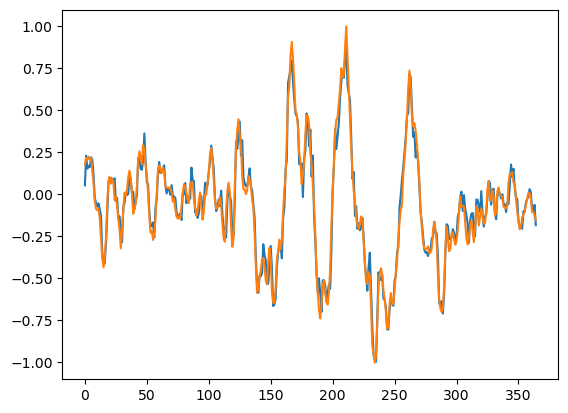

In [31]:
plt.figure()
plt.plot(GRU_predict[:time_window,mode])
plt.plot(GRU_truth[:time_window,mode])
plt.show()

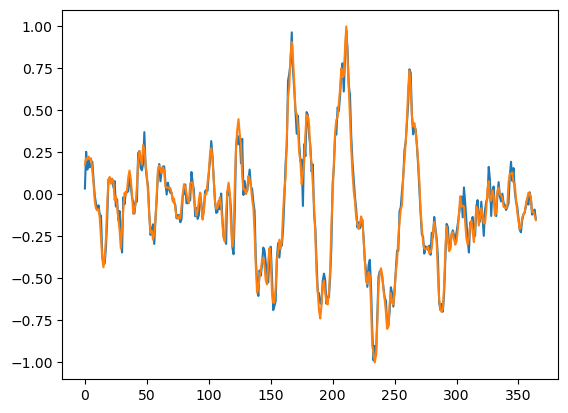

In [32]:
plt.figure()
plt.plot(VAR_predict[:time_window, mode])
plt.plot(VAR_truth[:time_window, mode])
plt.show()

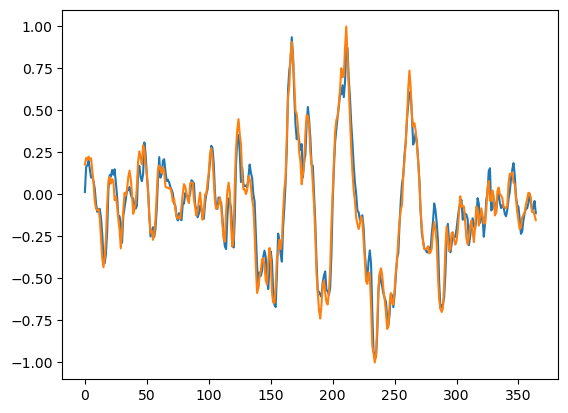

In [33]:
plt.figure()
plt.plot(ESN_predict[:time_window, mode])
plt.plot(ESN_truth[:time_window, mode])
plt.show()

# Unused blocks